In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import joblib
from scipy import stats
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Trabalho II - IA/Bases de dados finais/sample_balanced.csv")

df = df[(df['TX_EV_TOT'] != 100) | (df['TX_REPR_FUND'] != 100)]

df2 = pd.read_csv("/content/drive/MyDrive/Trabalho II - IA/Bases de dados finais/sample.csv")
df_nova_base = pd.read_csv("/content/drive/MyDrive/Trabalho II - IA/Bases de dados finais/base-escolas-evasao-categorico.csv")
df_tx_num = pd.read_csv("/content/drive/MyDrive/Trabalho II - IA/Bases de dados finais/base-escolas-evasao.csv")
df_norm = df.copy()

numeric_features = df_norm.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
df_norm[numeric_features] = scaler.fit_transform(df_norm[numeric_features])

target_column = df_norm.columns[-1]
df_norm[target_column] = df_norm[target_column].map({'Baixa': 1, 'Moderada': 2, 'Alta': 3})

df_nova_base.head()

,NO_REGIAO,SG_UF,CO_MUNICIPIO,NO_MUNICIPIO,CO_ENTIDADE,NO_ENTIDADE,NO_CATEGORIA,NO_DEPENDENCIA,TX_APROV_FUND,TX_APROV_MED,...,QT_PROF_BIBLIOTECARIO,QT_PROF_SAUDE,QT_PROF_ALIMENTACAO,QT_PROF_SEGURANCA,QT_PROF_GESTAO,QT_TUR_FUND,QT_TUR_MED,PIB_MUN,PIB_PC_MUN,TX_EV_TOT
0,Norte,RO,1100015.0,Alta Floresta D'Oeste,11022558.0,EIEEF HAP BITT TUPARI,Rural,Estadual,100.0,86.8,...,0.0,0.0,0.0,0.0,0.0,5,0,734469.3,32619.9,Baixa
1,Norte,RO,1100015.0,Alta Floresta D'Oeste,11024291.0,EMMEF 7 DE SETEMBRO,Rural,Municipal,100.0,86.8,...,0.0,0.0,0.0,0.0,0.0,1,0,734469.3,32619.9,Baixa
2,Norte,RO,1100015.0,Alta Floresta D'Oeste,11024372.0,EMEIEF ANA NERY,Urbana,Municipal,92.3,86.8,...,0.0,0.0,3.0,2.0,0.0,7,0,734469.3,32619.9,Baixa
3,Norte,RO,1100015.0,Alta Floresta D'Oeste,11024666.0,EMEIEF BOA ESPERANCA,Rural,Municipal,99.3,86.8,...,0.0,0.0,2.0,2.0,0.0,8,0,734469.3,32619.9,Baixa
4,Norte,RO,1100015.0,Alta Floresta D'Oeste,11024682.0,EEEFM EURIDICE LOPES PEDROSO,Urbana,Estadual,100.0,90.8,...,4.0,0.0,4.0,0.0,1.0,16,27,734469.3,32619.9,Baixa


# Análise exploratória de dados

## Histograma das classes

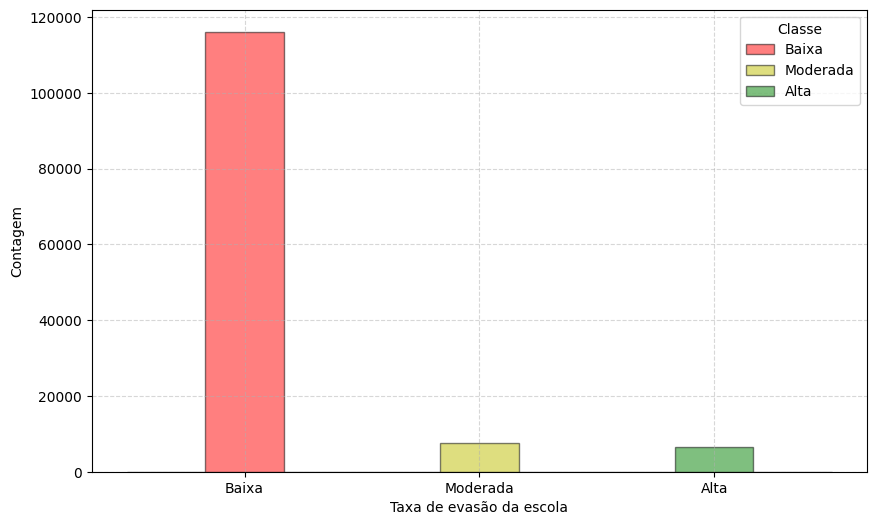

In [ ]:
class_order = ['Baixa', 'Moderada', 'Alta']
colors = ['r', 'y', 'g']
bins = 3

plt.figure(figsize=(10, 6))

for i, class_label in enumerate(class_order):
    subset = df_nova_base[df_nova_base['TX_EV_TOT'] == class_label]
    plt.hist(subset['TX_EV_TOT'], bins=bins, alpha=0.5, label=class_label, color=colors[i], edgecolor='k')

plt.xlabel('Taxa de evasão da escola')
plt.ylabel('Contagem')
plt.grid(linestyle="--",alpha=0.5,zorder=-1)
plt.legend(title='Classe')

## Distribuição das escolas com altas taxas de acordo com o estado

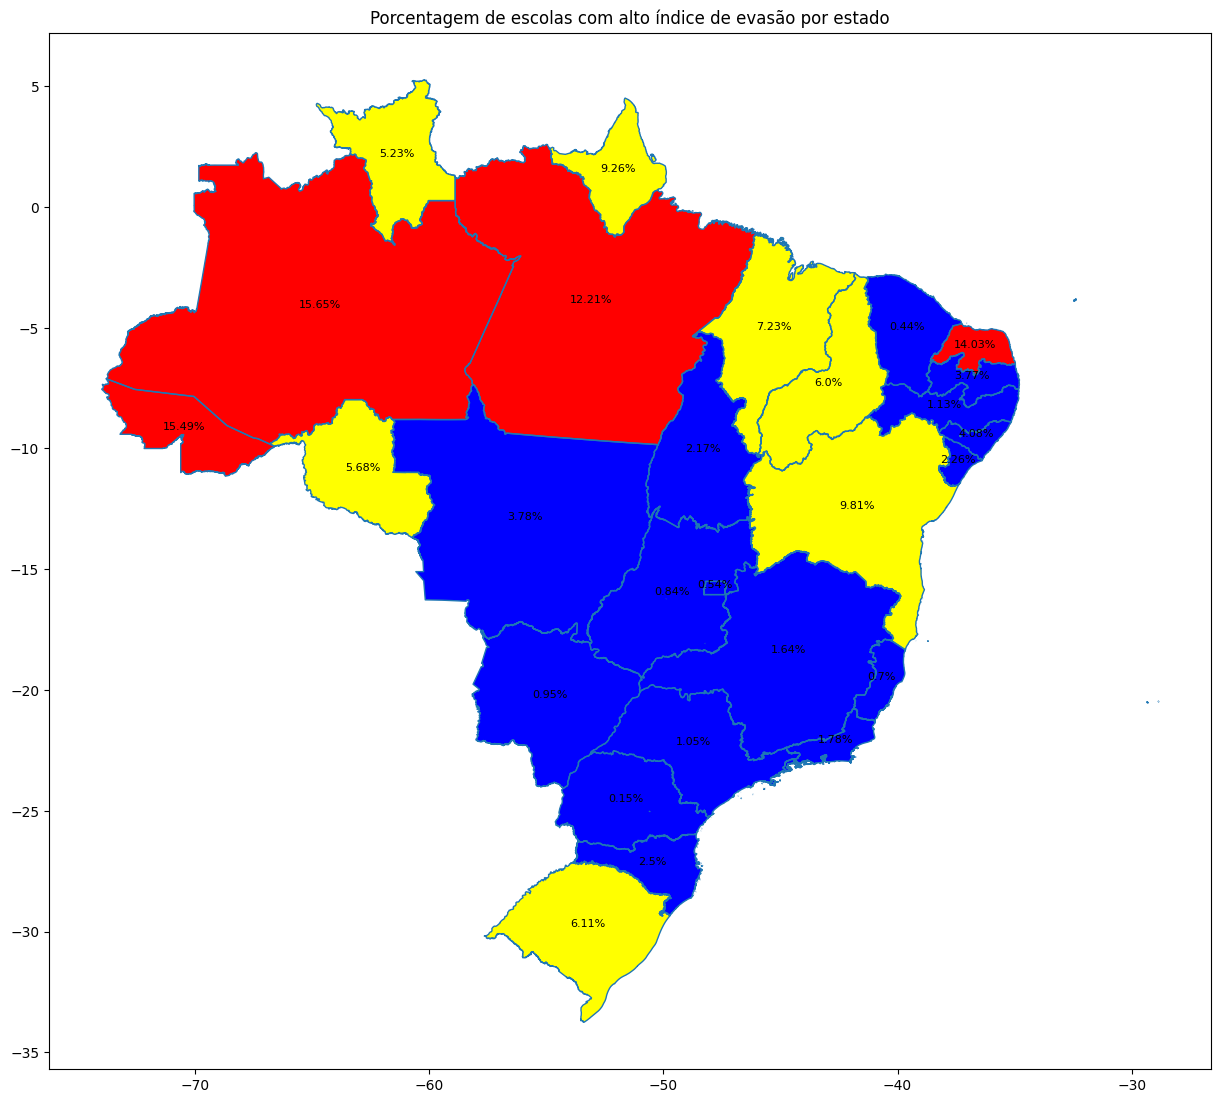

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

df = pd.read_csv('/content/evasao_alto.csv')

shapefile = '/content/BR_UF_2022.shp'
map_df = gpd.read_file(shapefile)

map_df = map_df.merge(df, how="left", left_on="SIGLA_UF", right_on="SG_UF")

def get_color(evasao):
    if evasao >= 10:
        return 'red'
    elif 5 <= evasao < 10:
        return 'yellow'
    elif evasao < 5:
        return 'blue'
    else:
        return 'grey'

map_df['color'] = map_df['TX_EV_TOT'].apply(get_color)

fig, ax = plt.subplots(1, figsize=(15, 15))
map_df.boundary.plot(ax=ax, linewidth=1)
map_df.plot(ax=ax, color=map_df['color'])

for idx, row in map_df.iterrows():
    plt.annotate(text=f"{row['TX_EV_TOT']}%", xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8, color='black')

plt.title('Porcentagem de escolas com alto índice de evasão por estado')
plt.show()

## Gráficos de dispersão

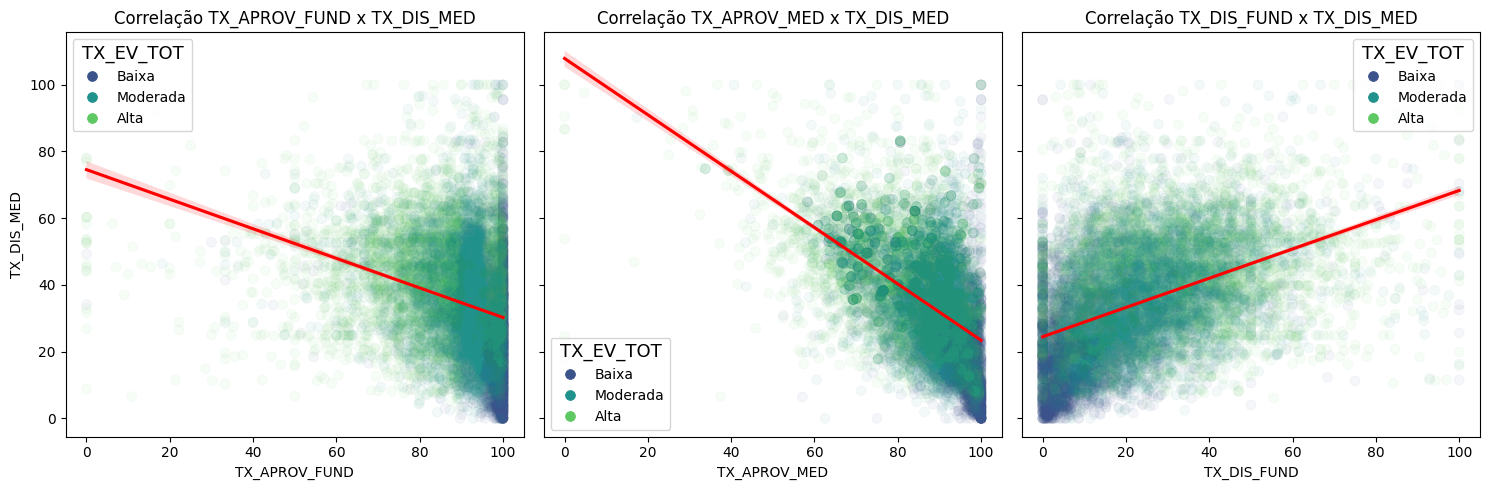

In [ ]:
def plot_scatter_matrix(data, attributes, target):
    num_attributes = len(attributes)
    hue_column = data.columns[-1]

    category_order = ['Baixa', 'Moderada', 'Alta']

    if num_attributes == 1:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        sns.scatterplot(ax=ax, data=data, x=attributes[0], y=target, hue=hue_column, palette='viridis', hue_order=category_order, s=50, alpha=0.6, edgecolor=None)
        sns.regplot(ax=ax, x=attributes[0], y=target, data=data, scatter=False, color='red')
        ax.set_title(f'Correlação {attributes[0]} x {target}')
        ax.set_xlabel(attributes[0])
        ax.set_ylabel(target)
    else:
        fig, axes = plt.subplots(1, num_attributes, figsize=(5 * num_attributes, 5), sharey=True)

        for i, attr in enumerate(attributes):
            scatter = sns.scatterplot(ax=axes[i], data=data, x=attr, y=target, hue=hue_column, palette='viridis', hue_order=category_order, s=50, alpha=0.05, edgecolor=None)
            sns.regplot(ax=axes[i], x=attr, y=target, data=data, scatter=False, color='red')
            axes[i].set_title(f'Correlação {attr} x {target}')
            axes[i].set_xlabel(attr)
            axes[i].set_ylabel(target)

            handles, labels = scatter.get_legend_handles_labels()
            for handle in handles:
                handle.set_alpha(1)
            axes[i].legend(handles, labels, title=hue_column, title_fontsize='13', fontsize='10', frameon=True)

    plt.tight_layout()
    plt.show()

plot_scatter_matrix(df, ['TX_APROV_FUND','TX_APROV_MED', 'TX_DIS_FUND'], 'TX_DIS_MED')

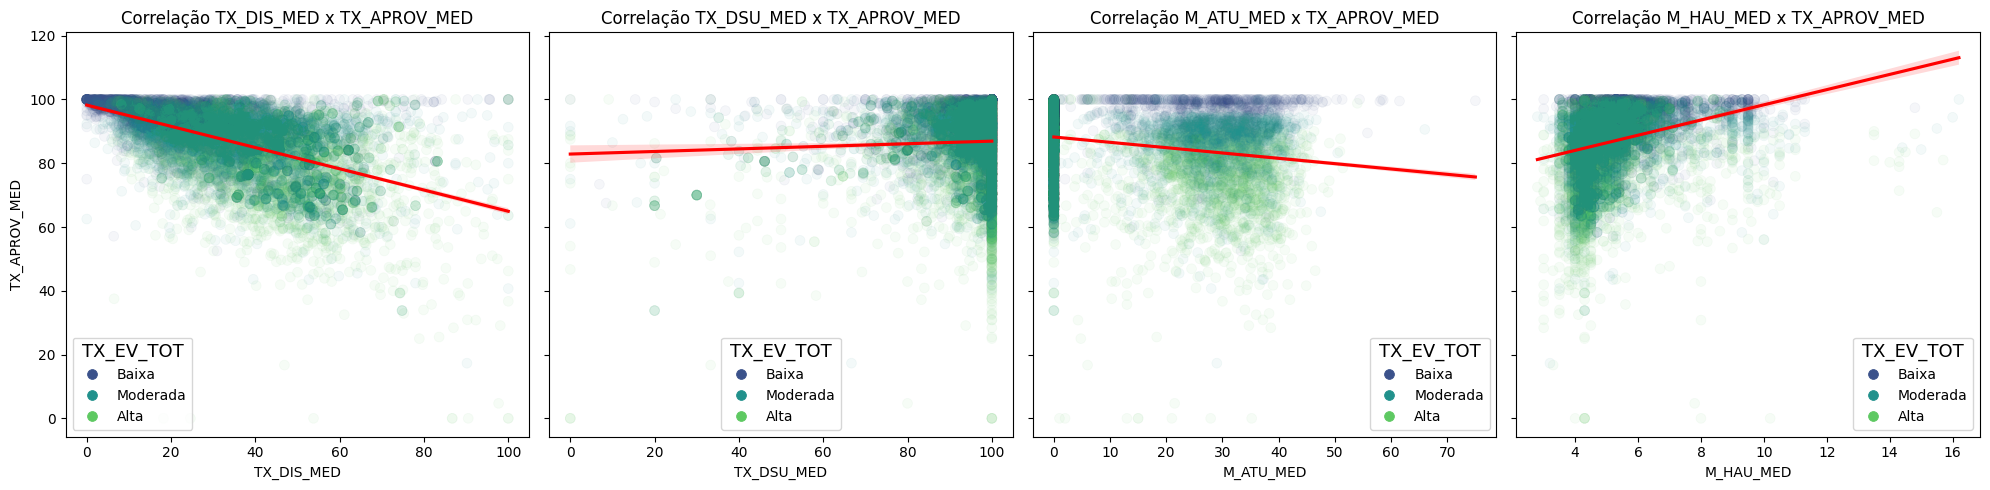

In [ ]:
plot_scatter_matrix(df, ['TX_DIS_MED', 'TX_DSU_MED', 'M_ATU_MED', 'M_HAU_MED'], 'TX_APROV_MED')

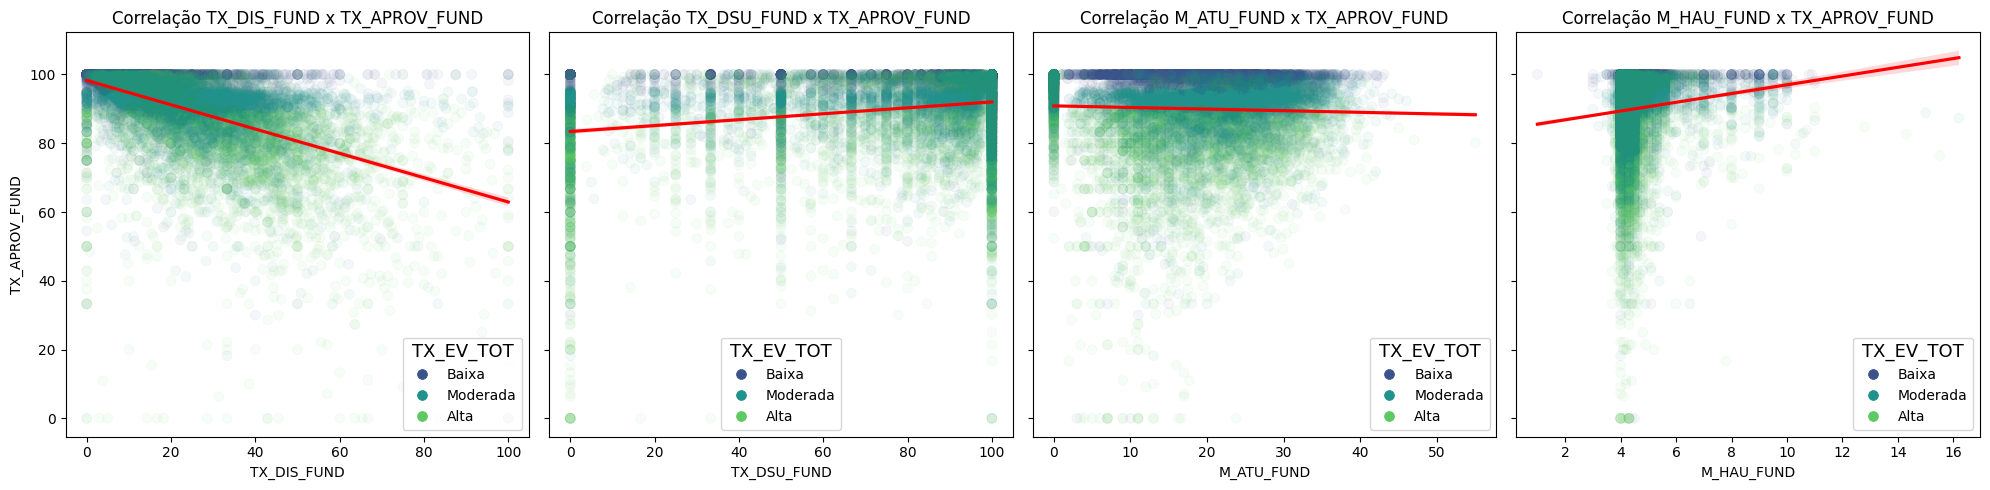

In [ ]:
plot_scatter_matrix(df, ['TX_DIS_FUND', 'TX_DSU_FUND', 'M_ATU_FUND', 'M_HAU_FUND'], 'TX_APROV_FUND')

## Mapas de calor

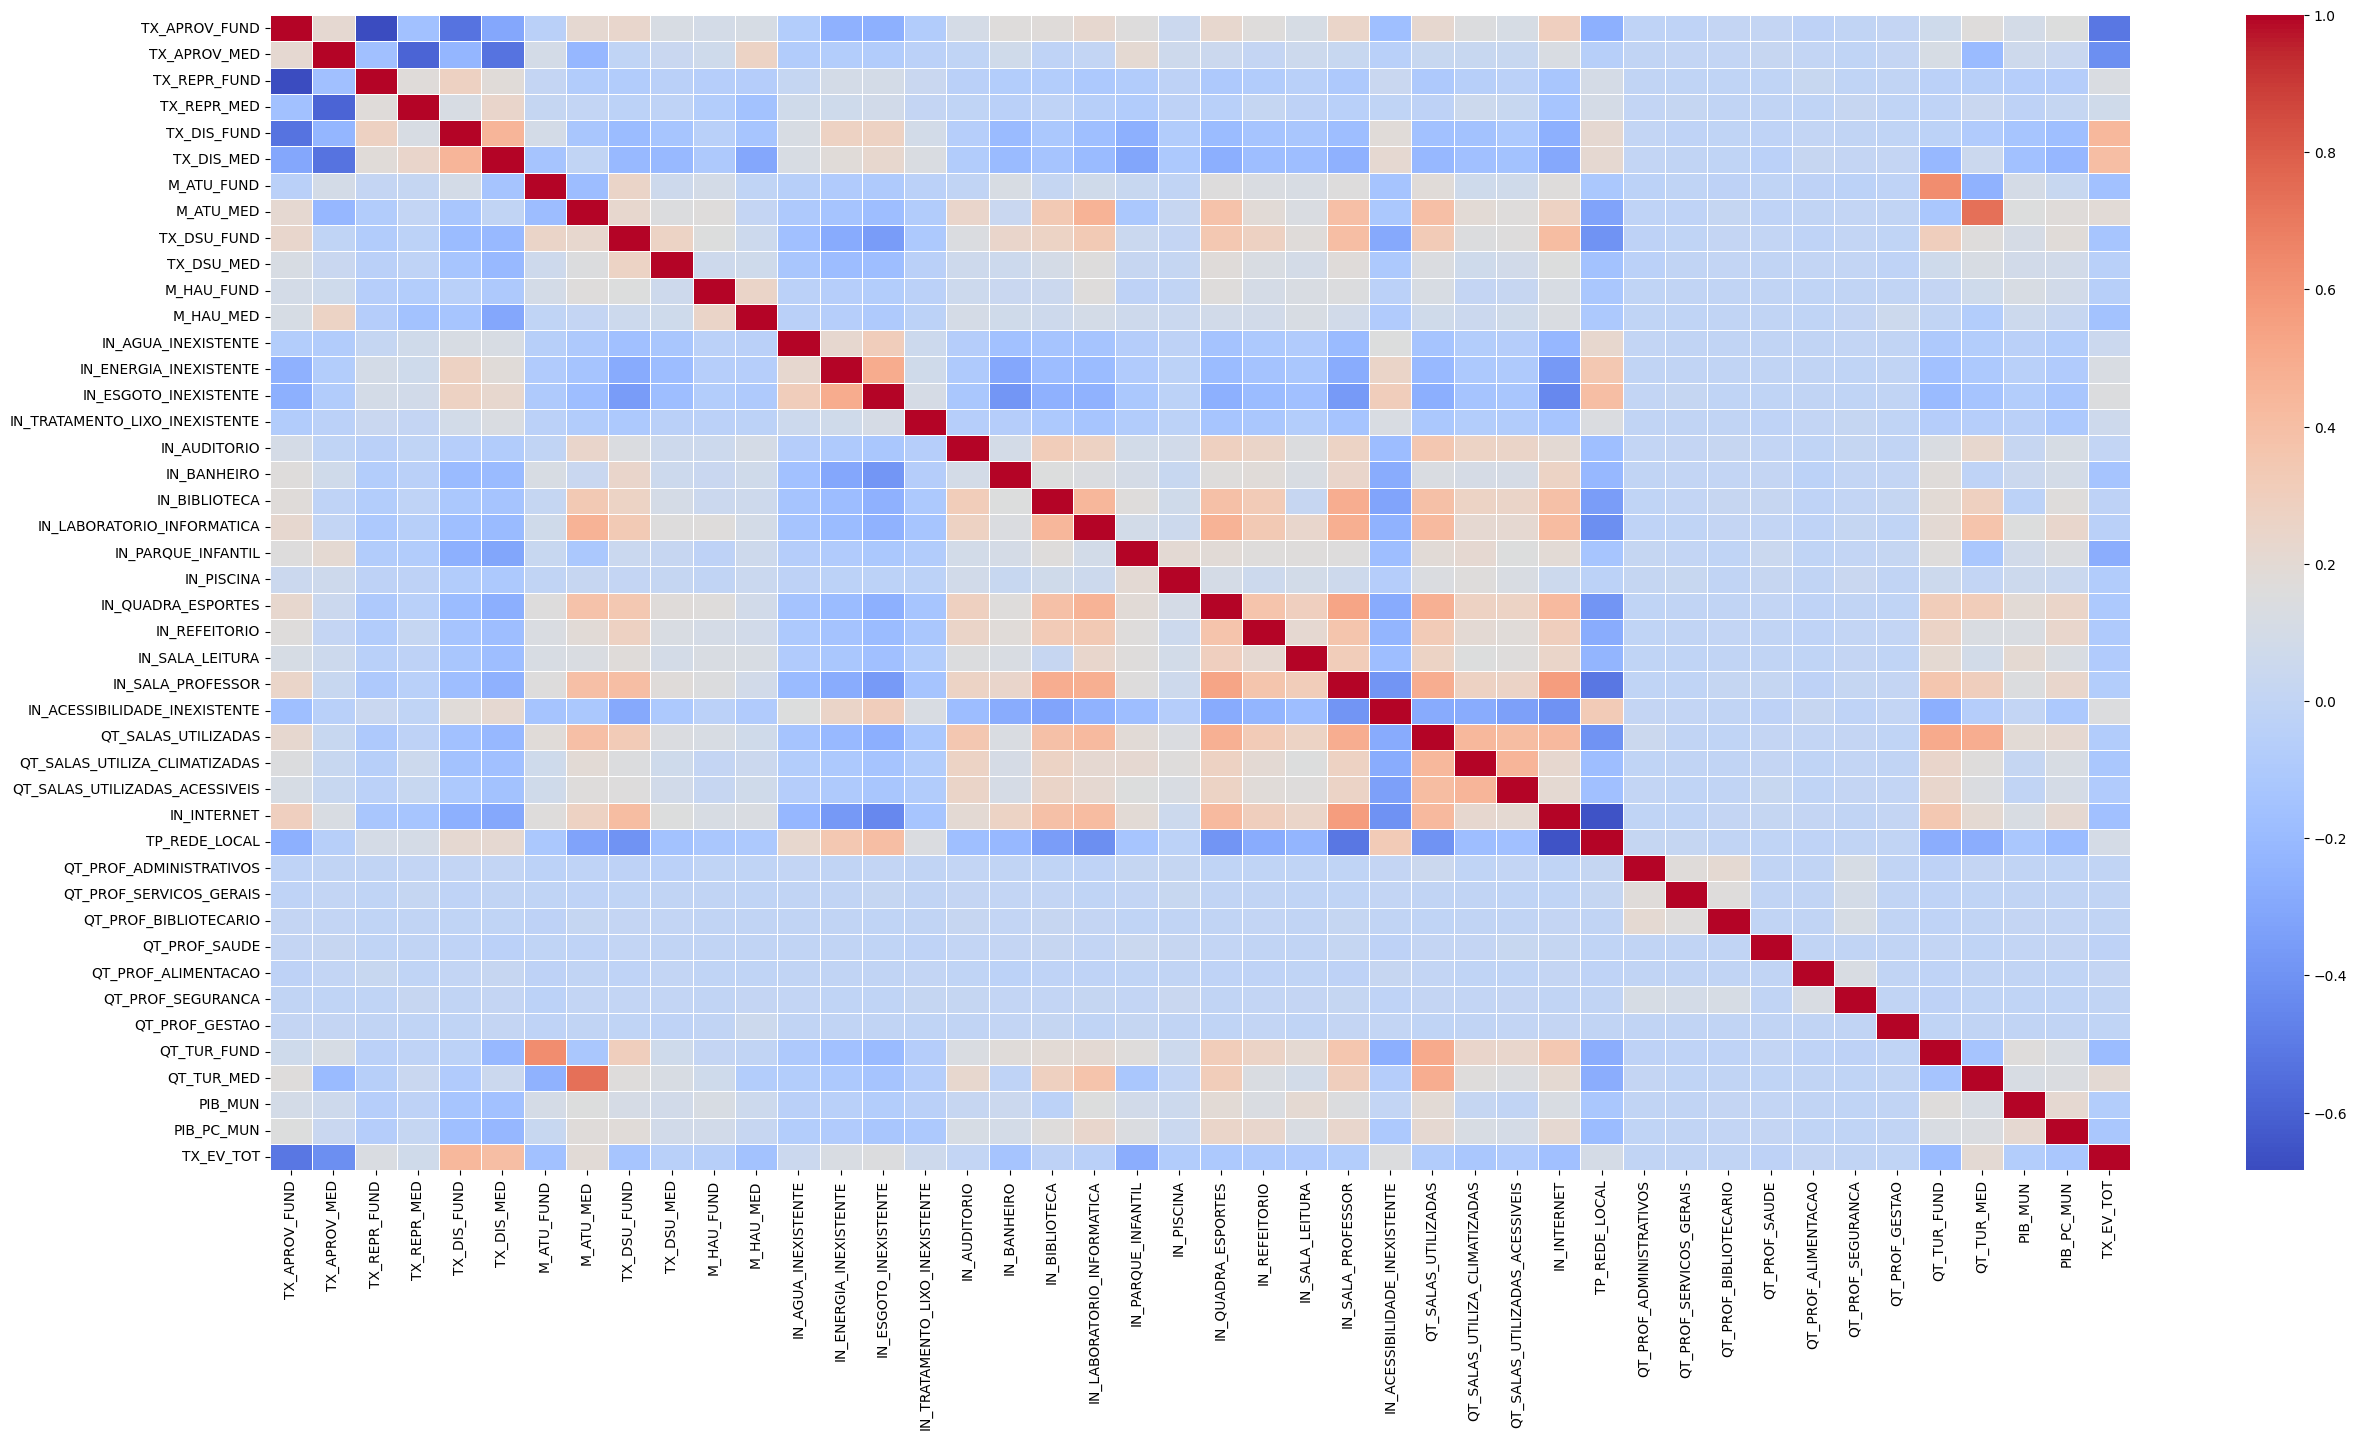

In [ ]:
numeric_df = df_norm.select_dtypes(include=['int64', 'float64']).drop(columns=['CO_ENTIDADE', 'CO_MUNICIPIO'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(30, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True, annot=False, linewidths=0.5)
plt.show()

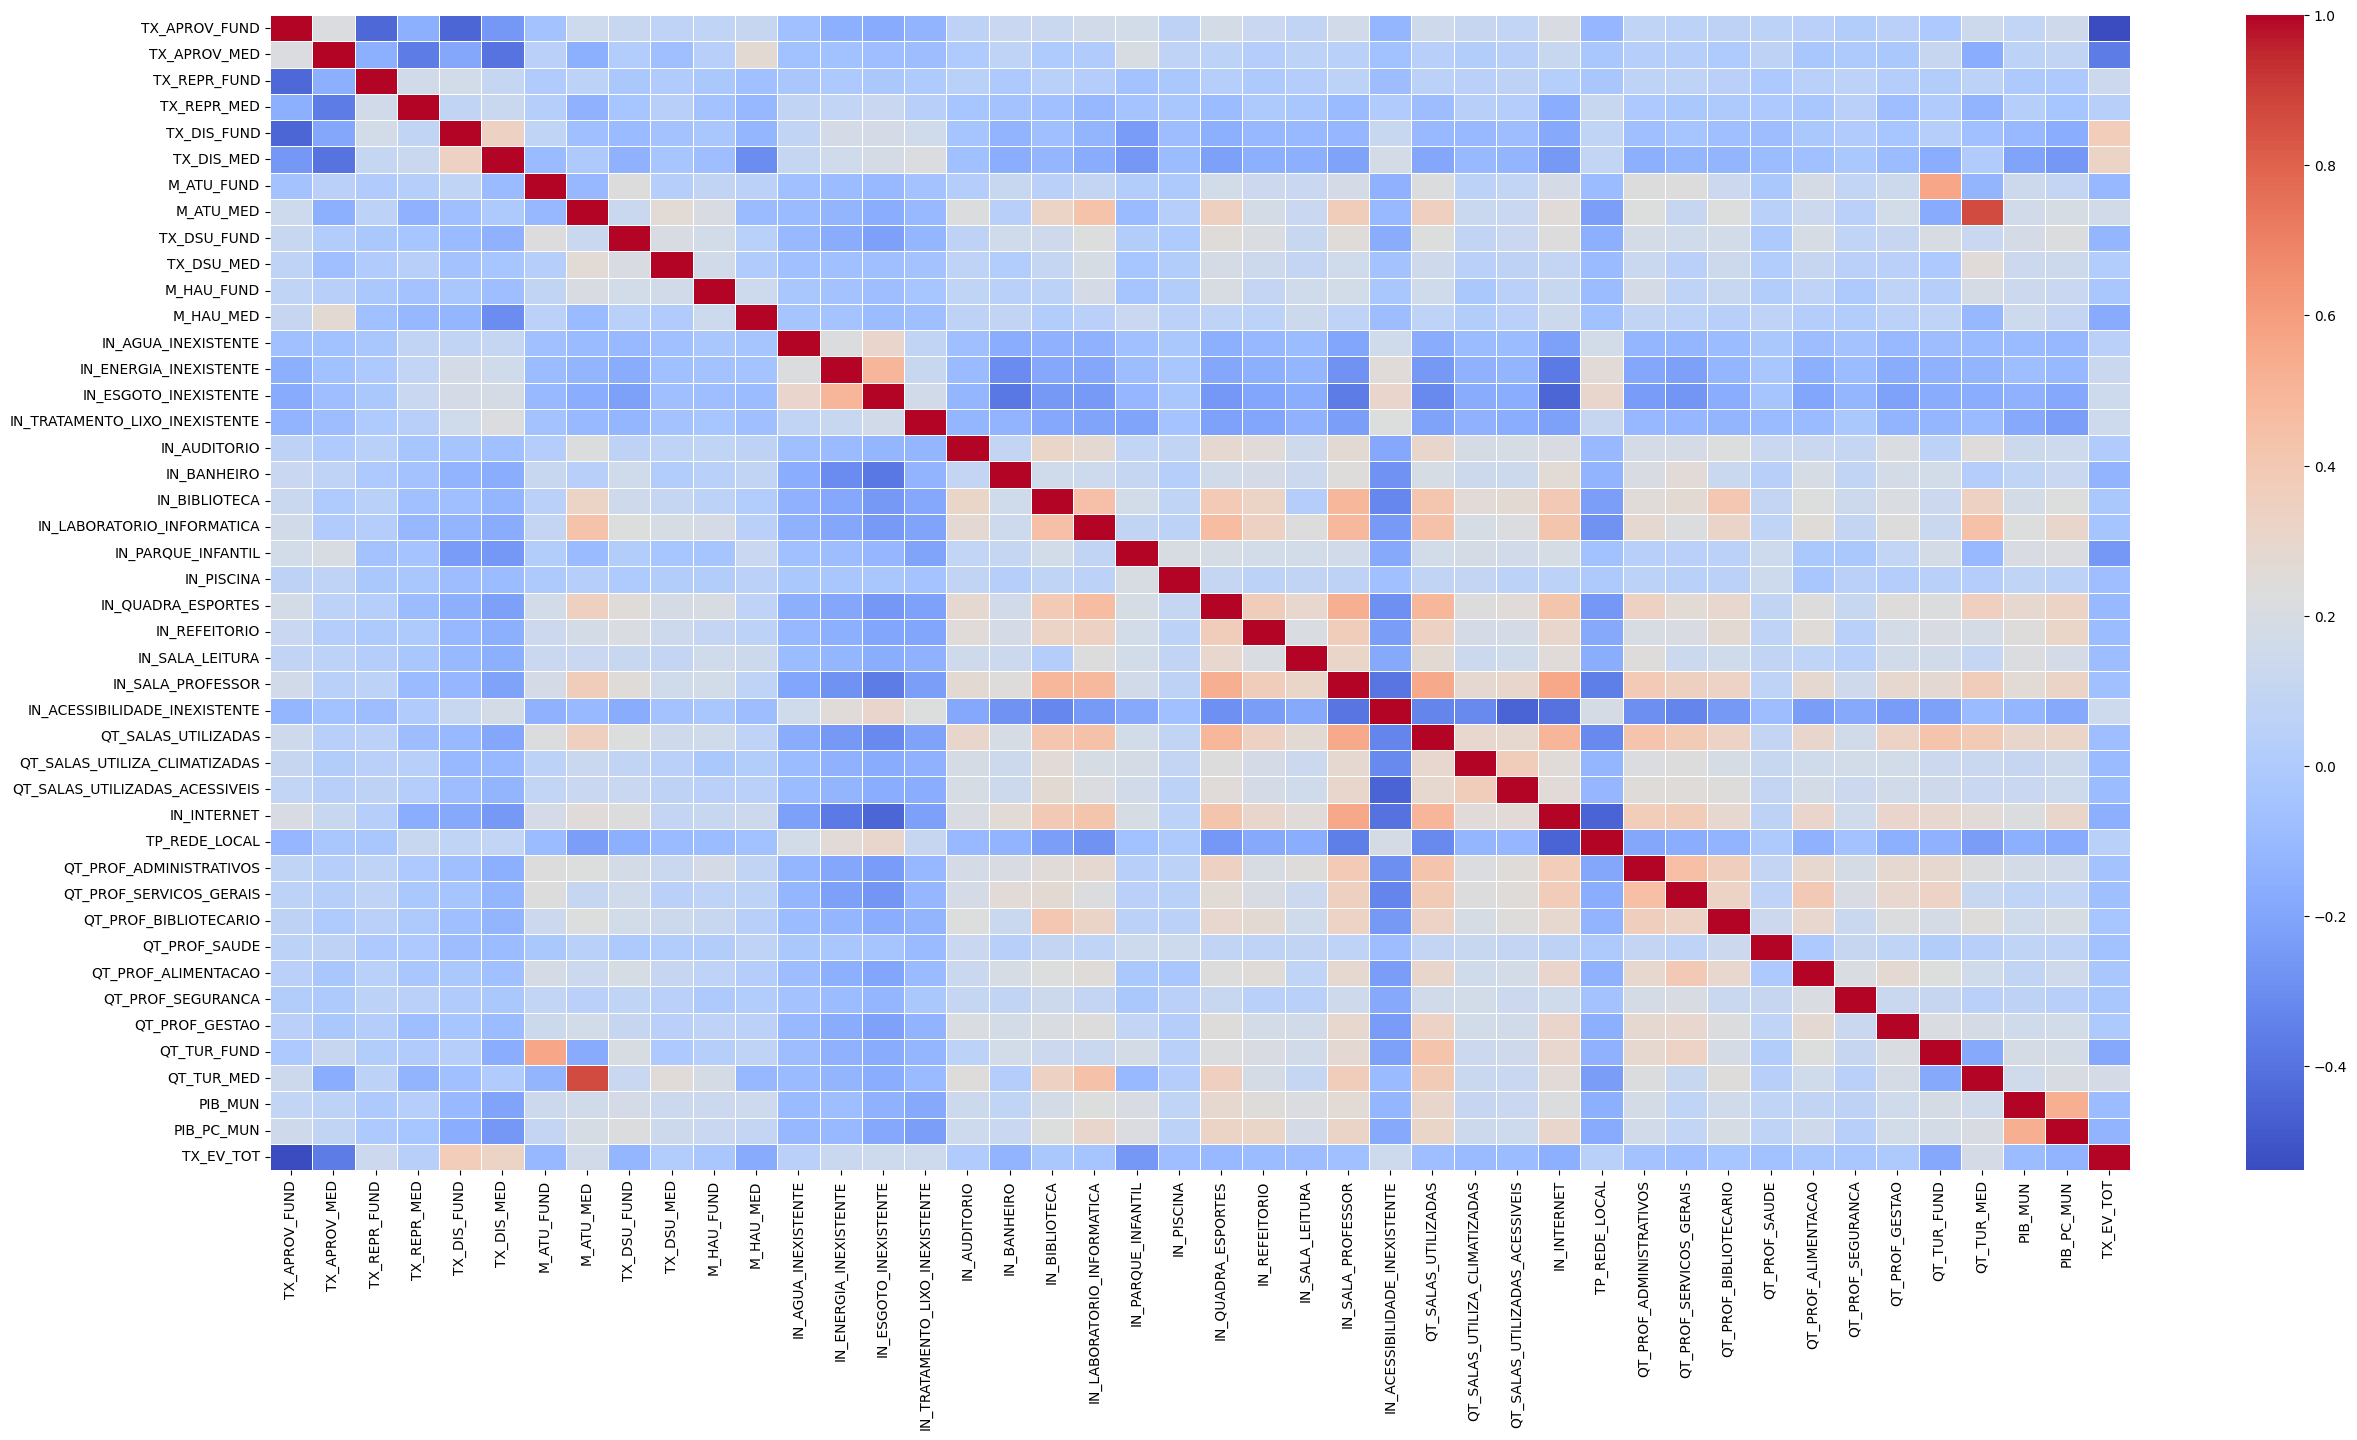

In [ ]:
numeric_df = df_norm.select_dtypes(include=['int64', 'float64']).drop(columns=['CO_ENTIDADE', 'CO_MUNICIPIO'])

corr_matrix = numeric_df.corr(method='kendall')

plt.figure(figsize=(30, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True, annot=False, linewidths=0.5)
plt.show()

## Gráficos violino

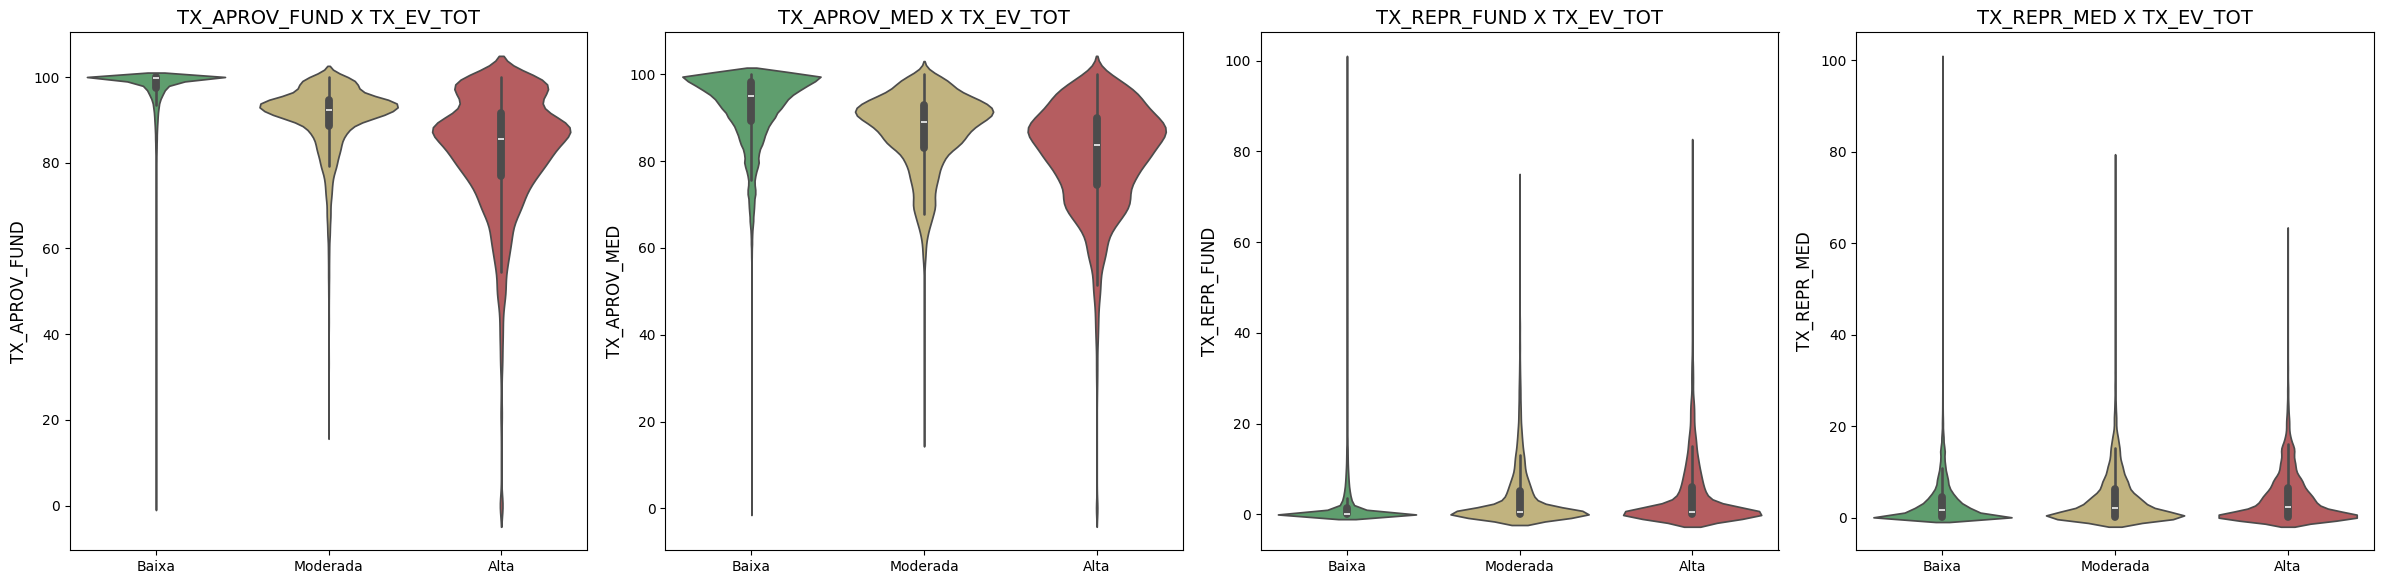

In [ ]:
def plot_violin_plots(data, attributes):
    target_column = data.columns[-1]

    num_attributes = len(attributes)
    fig, axes = plt.subplots(1, num_attributes, figsize=(6 * num_attributes, 6), sharey=False)

    category_order = ['Baixa', 'Moderada', 'Alta']

    sns.set(style="whitegrid")

    palette = ['g', 'y', 'r']

    for i, attr in enumerate(attributes):
        sns.violinplot(ax=axes[i], data=data, x=target_column, y=attr, hue=target_column, order=category_order, palette=palette, dodge=False)
        axes[i].set_title(f'{attr} X {target_column}', fontsize=14)
        axes[i].set_xlabel('')
        axes[i].set_ylabel(attr, fontsize=12)
        axes[i].tick_params(axis='x', labelsize=10)
        axes[i].tick_params(axis='y', labelsize=10)
        axes[i].legend([],[], frameon=False)

    plt.tight_layout()
    plt.show()

plot_violin_plots(df_nova_base, ['TX_APROV_FUND','TX_APROV_MED','TX_REPR_FUND','TX_REPR_MED'])

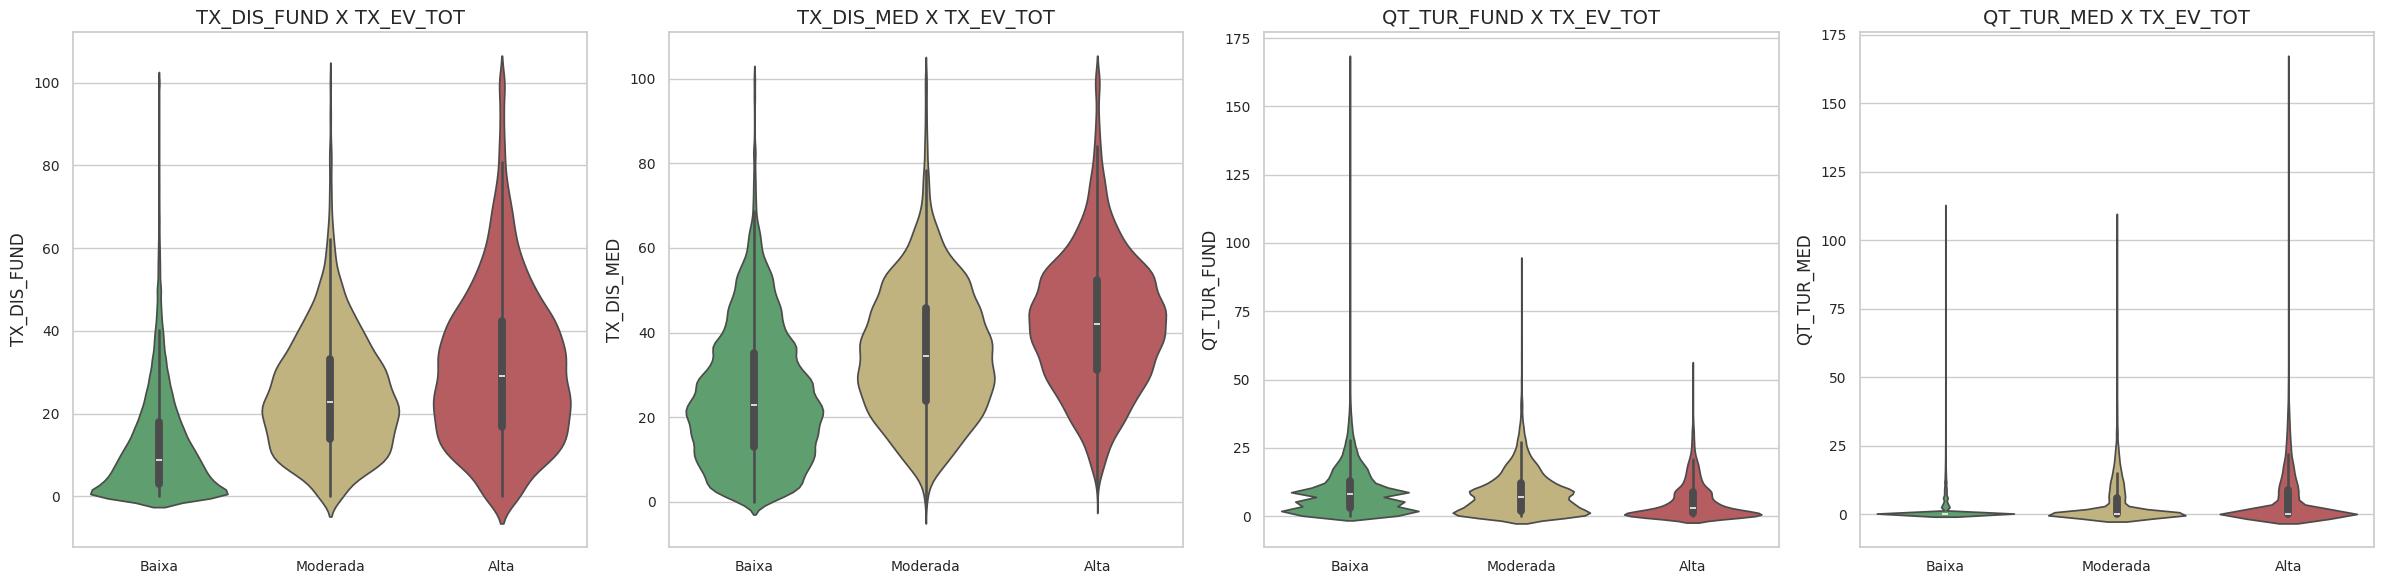

In [ ]:
plot_violin_plots(df_nova_base, ['TX_DIS_FUND','TX_DIS_MED','QT_TUR_FUND','QT_TUR_MED'])

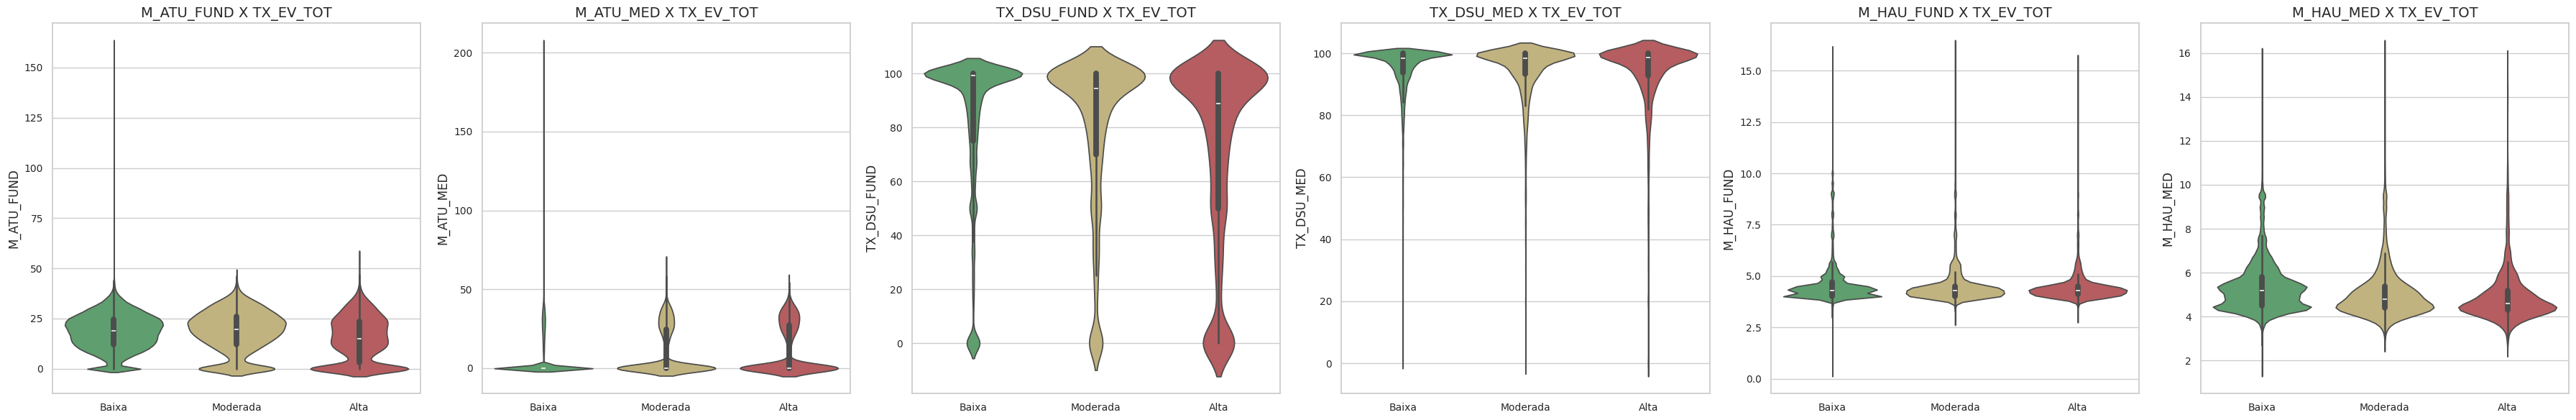

In [ ]:
plot_violin_plots(df_nova_base, ['M_ATU_FUND','M_ATU_MED','TX_DSU_FUND','TX_DSU_MED','M_HAU_FUND','M_HAU_MED'])

# Modelagem

## Random Forest - Amostra balanceada


In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Padronização
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Treinamento na amostra balanceada
y_pred = cross_val_predict(model, X, y, cv=kf)

report = classification_report(y, y_pred)
print("Relatório de Classificação:")
print(report)

model.fit(X, y)
joblib.dump(model, 'random_forest_model.joblib')

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.72      0.74      0.73      4420
       Baixa       0.86      0.83      0.85      4290
    Moderada       0.65      0.65      0.65      4290

    accuracy                           0.74     13000
   macro avg       0.74      0.74      0.74     13000
weighted avg       0.74      0.74      0.74     13000



['random_forest_model.joblib']

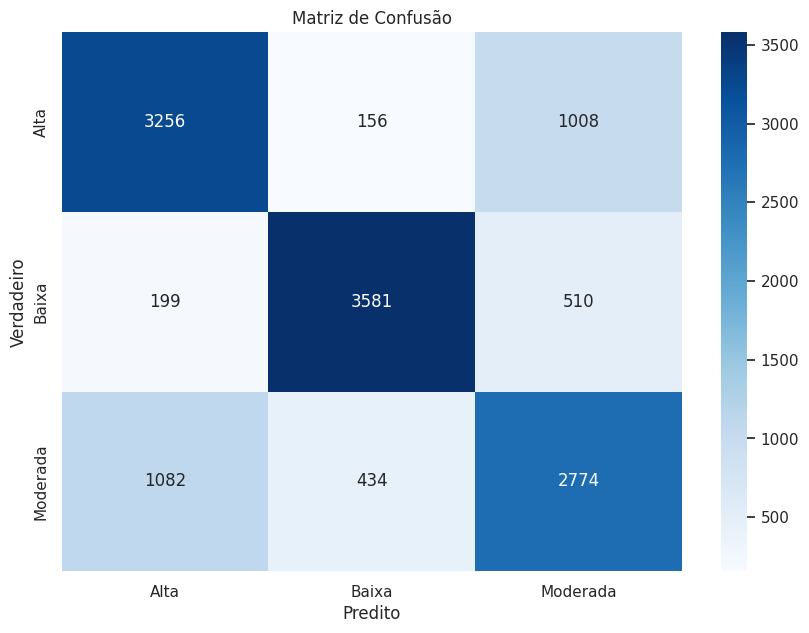

In [ ]:
ordered_classes = ['Alta', 'Baixa', 'Moderada']
conf_matrix = confusion_matrix(y, y_pred, labels=ordered_classes)

conf_matrix_df = pd.DataFrame(conf_matrix, index=ordered_classes, columns=ordered_classes)

# Exibir a tabela de confusão como um gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()

## Teste do modelo na base completa

In [ ]:
model = joblib.load('random_forest_model.joblib')

X_nova_base = df_nova_base.iloc[:, :-1]
y_nova_base = df_nova_base.iloc[:, -1]

y_pred_nova_base = model.predict(X_nova_base)

report = classification_report(y_nova_base, y_pred_nova_base)
print("Relatório de Classificação:")
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.52      0.92      0.66      6463
       Baixa       1.00      0.84      0.91    116150
    Moderada       0.31      0.85      0.46      7516

    accuracy                           0.85    130129
   macro avg       0.61      0.87      0.68    130129
weighted avg       0.93      0.85      0.87    130129



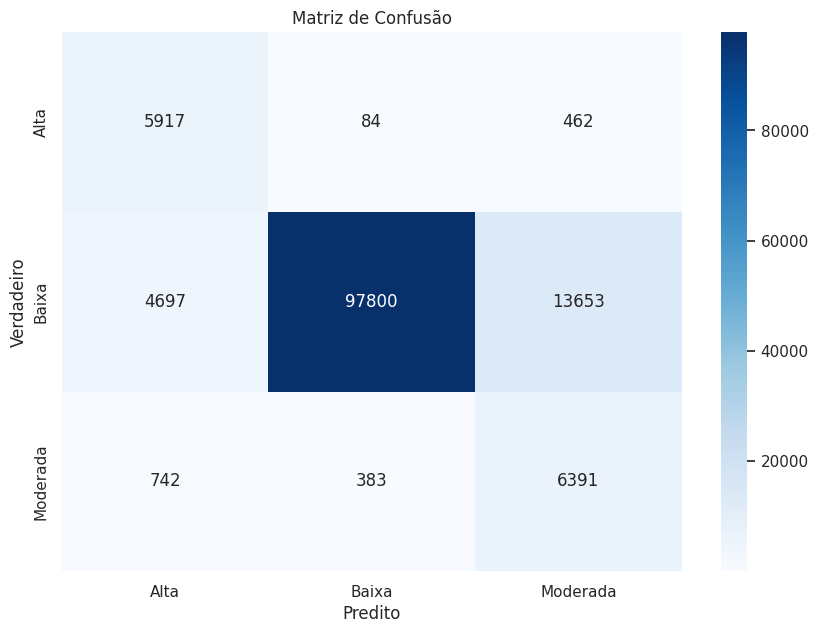

In [ ]:
ordered_classes = ['Alta', 'Baixa', 'Moderada']
conf_matrix = confusion_matrix(y_nova_base, y_pred_nova_base, labels=ordered_classes)

conf_matrix_df = pd.DataFrame(conf_matrix, index=ordered_classes, columns=ordered_classes)

# Exibir a tabela de confusão como um gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()

## Importâncias atribuídas pelo modelo

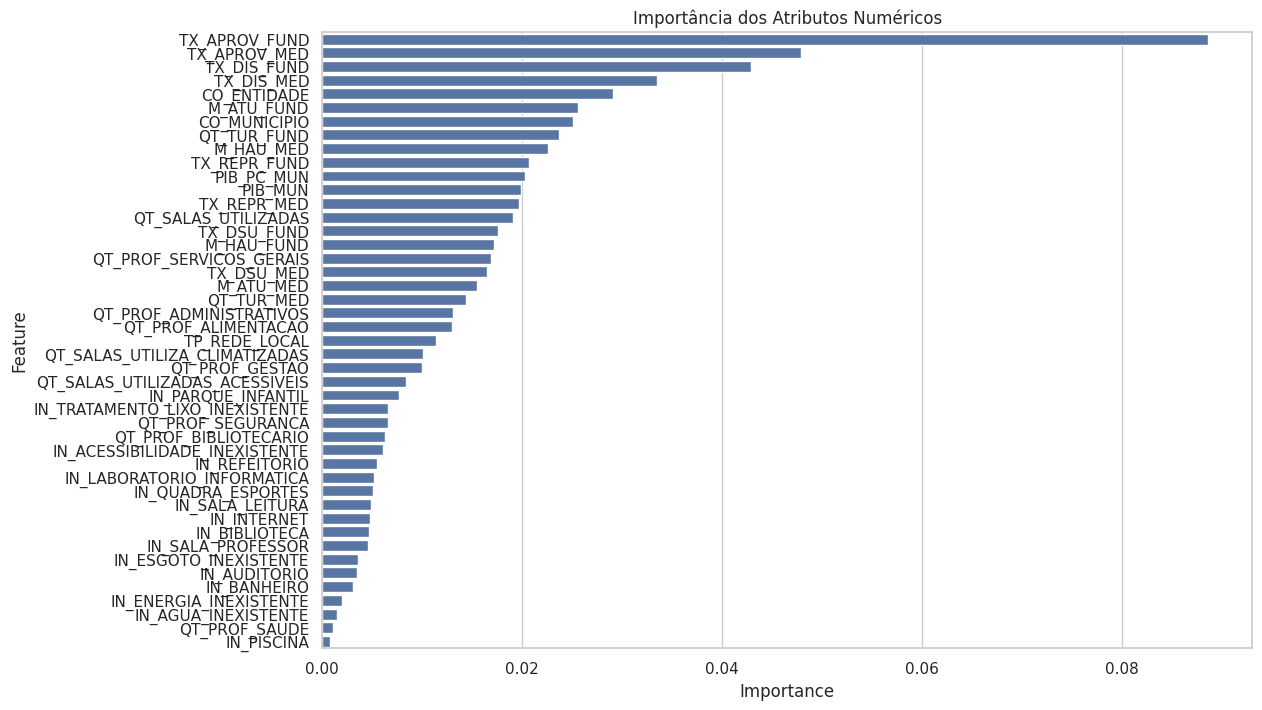

In [ ]:
importances = model.named_steps['classifier'].feature_importances_

feature_names = numeric_features.tolist()

num_importances = importances[:len(numeric_features)]

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': num_importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar as importâncias dos atributos numéricos
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importância dos Atributos Numéricos')
plt.show()

## Random Forest - Amostra aleatória

In [ ]:
X = df2.iloc[:, :-1]
y = df2.iloc[:, -1]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Treinamento na amostra aleatória
y_pred = cross_val_predict(model, X, y, cv=kf)

report = classification_report(y, y_pred)
print("Relatório de Classificação:")
print(report)

model.fit(X, y)
joblib.dump(model, 'random_forest_model.joblib')

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.81      0.15      0.26       650
       Baixa       0.91      1.00      0.95     11700
    Moderada       0.25      0.00      0.00       650

    accuracy                           0.91     13000
   macro avg       0.66      0.38      0.40     13000
weighted avg       0.87      0.91      0.87     13000



['random_forest_model.joblib']

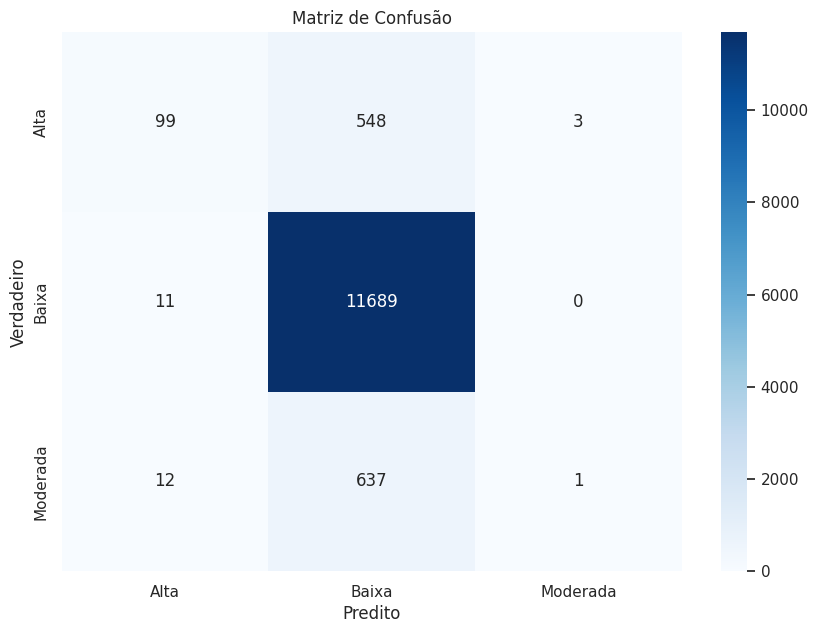

In [ ]:
ordered_classes = ['Alta', 'Baixa', 'Moderada']
conf_matrix = confusion_matrix(y, y_pred, labels=ordered_classes)

conf_matrix_df = pd.DataFrame(conf_matrix, index=ordered_classes, columns=ordered_classes)

# Exibir a tabela de confusão como um gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()

## Teste do modelo na base completa

In [ ]:
model = joblib.load('random_forest_model.joblib')

X_nova_base = df_nova_base.iloc[:, :-1]
y_nova_base = df_nova_base.iloc[:, -1]

# Fazer predições na nova base de dados
y_pred_nova_base = model.predict(X_nova_base)

report = classification_report(y_nova_base, y_pred_nova_base)
print("Relatório de Classificação:")
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.92      0.24      0.38      6463
       Baixa       0.91      1.00      0.95    116150
    Moderada       0.95      0.09      0.16      7516

    accuracy                           0.91    130129
   macro avg       0.93      0.44      0.50    130129
weighted avg       0.91      0.91      0.88    130129



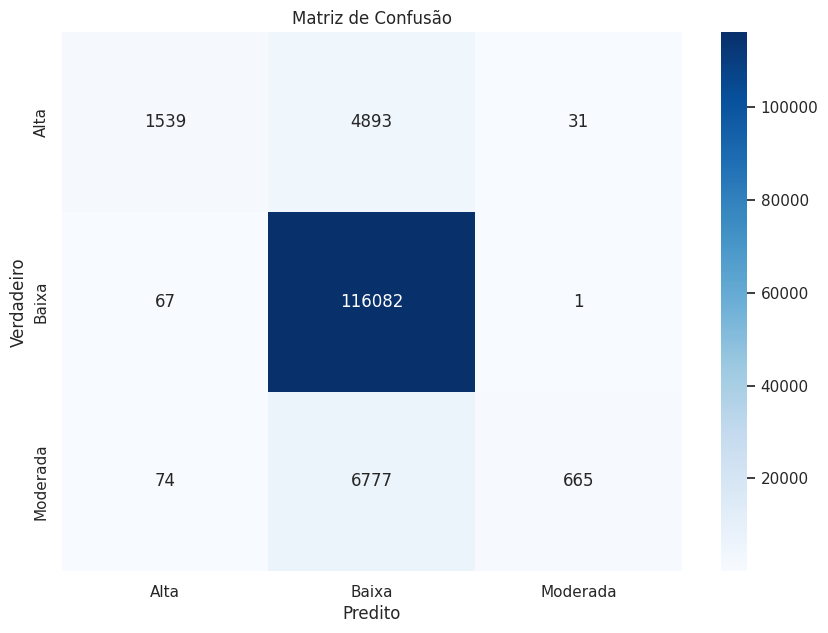

In [ ]:
ordered_classes = ['Alta', 'Baixa', 'Moderada']
conf_matrix = confusion_matrix(y_nova_base, y_pred_nova_base, labels=ordered_classes)

conf_matrix_df = pd.DataFrame(conf_matrix, index=ordered_classes, columns=ordered_classes)

# Exibir a tabela de confusão como um gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()

## Importâncias atribuídas pelo modelo

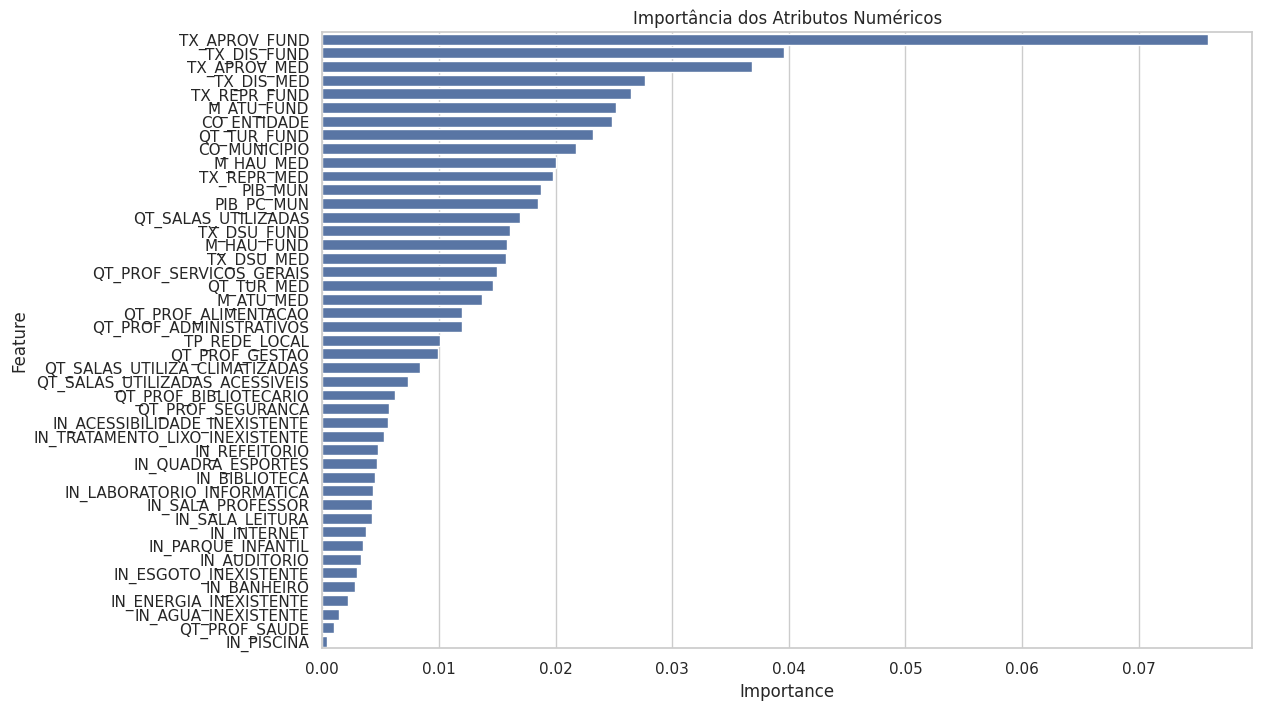

In [ ]:
importances = model.named_steps['classifier'].feature_importances_

feature_names = numeric_features.tolist()

num_importances = importances[:len(numeric_features)]

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': num_importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar as importâncias dos atributos numéricos
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importância dos Atributos Numéricos')
plt.show()

## Rede neural - Amostra aleatória

In [ ]:
X = df2.iloc[:, :-1]
y = df2.iloc[:, -1]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Padronização
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X = preprocessor.fit_transform(X).toarray()

onehot_encoder = OneHotEncoder(sparse_output=False)
y = onehot_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Treinamento na amostra aleatória
y_pred = model.predict(X_test)

y_pred_classes = onehot_encoder.inverse_transform(y_pred)
y_test_classes = onehot_encoder.inverse_transform(y_test)

from sklearn.metrics import classification_report, confusion_matrix
print("Relatório de Classificação:")
print(classification_report(y_test_classes, y_pred_classes))

print("Matriz de Confusão:")
print(confusion_matrix(y_test_classes, y_pred_classes))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1027520   
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                

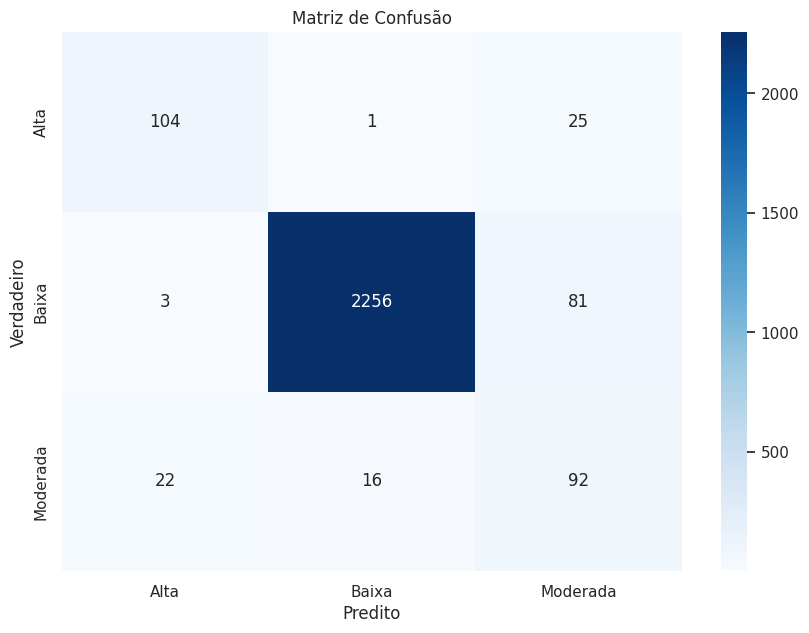

In [ ]:
ordered_classes = ['Alta', 'Baixa', 'Moderada']
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes, labels=ordered_classes)

conf_matrix_df = pd.DataFrame(conf_matrix, index=ordered_classes, columns=ordered_classes)

# Exibir a tabela de confusão como um gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()

## Rede neural - Amostra balanceada

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X = preprocessor.fit_transform(X).toarray()

onehot_encoder = OneHotEncoder(sparse_output=False)
y = onehot_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

#Treinamento na amostra balanceada
y_pred = model.predict(X_test)

y_pred_classes = onehot_encoder.inverse_transform(y_pred)
y_test_classes = onehot_encoder.inverse_transform(y_test)

from sklearn.metrics import classification_report, confusion_matrix
print("Relatório de Classificação:")
print(classification_report(y_test_classes, y_pred_classes))

print("Matriz de Confusão:")
print(confusion_matrix(y_test_classes, y_pred_classes))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                998976    
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 3)                

In [ ]:
model.save('rede_neural_model.h5')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(onehot_encoder, 'onehot_encoder.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['onehot_encoder.pkl']

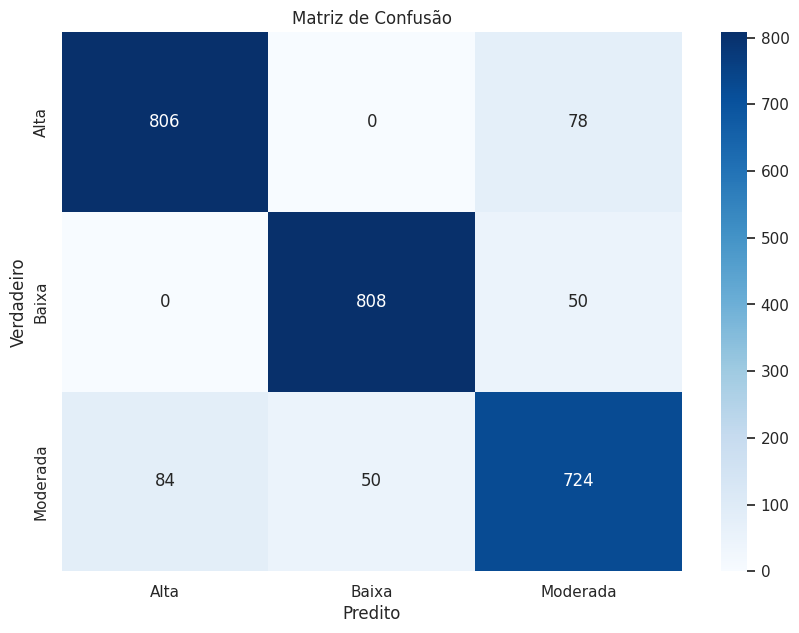

In [ ]:
ordered_classes = ['Alta', 'Baixa', 'Moderada']
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes, labels=ordered_classes)

conf_matrix_df = pd.DataFrame(conf_matrix, index=ordered_classes, columns=ordered_classes)

# Exibir a tabela de confusão como um gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()